# マルコフ連鎖モンテカルロ法(MCMC)

In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import scipy.stats as st
import copy

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

In [2]:
# 目標分布：２次元正規分布の確率密度関数から正規化定数を除いたもの
def P(x1, x2, b):
    assert np.abs(b) < 1
    return np.exp(-0.5*(x1**2 - 2*b*x1*x2 + x2**2))

In [3]:
# parameters
b = 0.5            # 対象分布の共分散
delta = 1          # 提案分布の標準偏差
dist_type = "norm" # 提案分布の種別("norm" or "unif")
print ("提案分布の種別:", dist_type)

num_frame = 150.   # アニメーションのトータルフレーム数

# サンプリング結果を格納するリスト
sample = []
# 1:accept, 0:rejectを格納するリスト
acc_rej = [] 

提案分布の種別: norm


Traceback (most recent call last):
  File "/Users/louis/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/louis/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/louis/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/Users/louis/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/louis/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/animation.py", line 1775, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.
MovieWriter imagemagick unavailab

0


ValueError: outfile must be *.htm or *.html

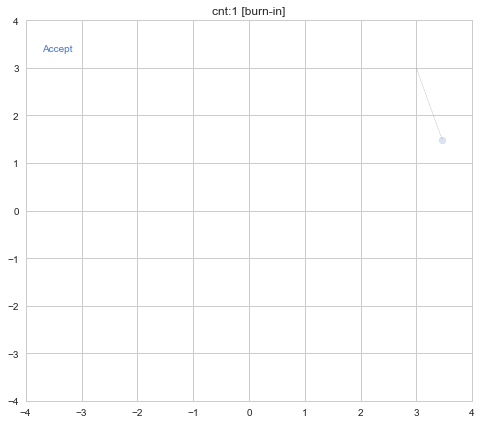

In [4]:
# 初期位置の設定とサンプリング結果リストへの格納
current = (3, 3)
sample.append(current)

# アニメーションの各フレームを描画する関数
def animate(nframe):
    global current, acc_rej
    print (nframe)      # 進捗状況の表示

    # 提案分布による次のステップの選択
    # dist_type: "norm":正規分布 / "unif"：一様分布
    if dist_type == "norm":
        next = (current[0] + rd.normal(0, delta), current[1] + rd.normal(0, delta))
    else:
        next = (current[0] + rd.uniform(-delta, delta), current[1] + rd.uniform(-delta, delta))
    # 各位置における目標分布の確率密度の比・・・[[1]]
    P_prev = P(current[0], current[1], b)   # 現在位置における目標分布の確率密度(に比例した数値)
    P_next = P(next[0], next[1], b)         # 次の候補位置における目標分布の確率密度(に比例した数値)

    # 上記の２つの値の比をとる
    r = P_next/P_prev

    # グラフの左上にAccept / Reject を表示する枠を表示
    ax = fig.add_subplot(111)
    rect = plt.Rectangle((-3.8,3.2), 1.1, .5,fc="#ffffff", zorder=nframe)
    ax.add_patch(rect)

    # 現在位置から次の候補位置への移動パスを表す点線を引く
    plt.plot([current[0], next[0]], [current[1], next[1]], "k--", lw=.3, color="gray") 

    if r > 1 or r > rd.uniform(0, 1):     # ・・・[[2]]
        # 0-1の一様乱数がrより大きい時は状態を更新する。 
        current = copy.copy(next)
        # サンプリングした値をリストに詰める。
        sample.append(current) 

        if nframe < num_frame*.2:
            # イテレーション回数の最初の20%はBurn-in期間と考える(プロットの色を薄くして示す）
            alpha = 0.2
        else:
            # 通常期間は点の濃さを戻す
            alpha = 0.8
            # acceptを記録
            acc_rej.append(1)

        # 採択(Accept)なので、点をプロットする。
        plt.scatter(current[0], current[1], alpha=alpha)
        plt.text(-3.7, 3.35, "Accept", zorder=nframe, fontdict={'color':"b"})

    else:  
        # 0-1の一様乱数がrより小さい時は棄却する。 
        # 棄却した時は x印をプロットする。
        plt.scatter(next[0], next[1], alpha=0.5, color="r", marker="x")
        plt.text(-3.7, 3.35, "Reject", zorder=nframe, fontdict={'color':"r"})

        if nframe <= num_frame*.2:
            # rejectを記録
            acc_rej.append(0)

    if nframe >= num_frame*.2:
        plt.title("cnt:{}".format(nframe+1))
    else:
        plt.title("cnt:{} [burn-in]".format(nframe+1))

    # グラフの描画範囲の設定
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)


fig = plt.figure(figsize=(8,7))
anim = ani.FuncAnimation(fig, animate, frames=int(num_frame), blit=True)
anim.save('metropolis_norm.gif', writer='imagemagick', fps=3, dpi=96)

# 採択(Accept)率の計算
print ("Accept ratio:{0:.5f}".format(np.mean(acc_rej)))